In [88]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import sentiment_to_vector
from lstm_utils import get_tokenizer, get_best_tokens_dummy

from sklearn.utils import shuffle

from keras.layers import Dense, LSTM
from keras.models import Model, Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#--
import re
import nltk
from nltk.stem.snowball import SnowballStemmer



In [140]:
# -------------- Hiperparametros -----------------

vector_size = 10
each_q = 128
batch_size = 2000
epoch = 256
min_lenght, max_length = 4, 8
train_to_test = 0.8

In [90]:
def map_rate_to_vector(r):
    if(str(r) == 'positive'):
        return [1, 0]
    else:
        return [0, 1]

In [128]:

re_points = re.compile("\\.")
re_symbols = re.compile("\\,|\\-|\\!|\\¡|\\(|\\)")
re_points_and_spaces = re.compile(" |\\.")
re_no = re.compile("NOO*(\\!|\\?|\\.|\\,)*")
stemmer = SnowballStemmer("spanish")


def inject_no(row):
    raw = str(row["raw"])
    content = row["content"]
    
    upper = raw.upper()
    clean = re_symbols.sub("", upper)
    clean = re_points.sub(" ", clean)
    tokens = nltk.word_tokenize(clean, 'spanish')
    
    newSentenceAsList = []
    for t in tokens:
        s = stemmer.stem(t).upper()
        if(re_no.match(t) or s in content):
            newSentenceAsList.append(s)
            
    string = " ".join(newSentenceAsList)
    row["content"] = string
    return row

In [141]:
# Leemos los archivos
corpus = pd.read_csv("pos_neg_standford_with_no.csv")

# Filtramos por longitud
debug("[El corpus tiene " + str(len(corpus)) + " rows]")

#corpus["length"] = corpus["content"].map(lambda x: len(str(x).split(" ")))
#corpus = corpus[(corpus["length"] >= min_lenght) & (corpus["length"] <= max_length)]

debug("[Luego de filtrar el corpus tiene " + str(len(corpus)) + " rows]")
corpus["sentiment"] = corpus["rate"].map(map_rate_to_vector)
corpus["content"] = corpus["content"].apply(str)
#corpus = corpus.apply(inject_no, axis=1)

#Shuffleamos el corpus
corpus = shuffle(corpus)
corpus.reset_index(inplace=True, drop=True)

#corpus.head()

[El corpus tiene 20000 rows]
[Luego de filtrar el corpus tiene 20000 rows]


In [142]:
# Seleccionamos los mejores tokens
best_tokens = get_best_tokens_dummy(corpus, each_q)
max_features = best_tokens.size

tokenizer = get_tokenizer(best_tokens, vector_size)

# Vectorizamos
debug("[Vectorizando corpus... ]")
corpus['vector'] = tokenizer(corpus['content'])

corpus.head()

[Vectorizando corpus... ]


,Unnamed: 0,Unnamed: 0.1,content,sentiment,raw,rate,vector
0,10903,4365,BUEN PRODUCT ? RECOM,"[1, 0]",Magico Hola muy buen productos?lo recomiendo,positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,5291,8465,COMPR NO TEN CAMBI ENVI DIFERENT DINER QUE BUE...,"[0, 1]","Malo COMPRE UN PRODUCTO PERO NO TENÍAN STOCK, ...",negative,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,88,988,COMOD COMOD SENSIBL TACT +10,"[1, 0]",Comodo bastante comodo y sensible al tacto +10,positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,2006,11169,BUEN EXCELENT EXCELENT ENTREG PACT,"[1, 0]","Muy bueno! Excelente Excelente, y además entr...",positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,3399,12567,BUEN BUEN CALID GUST,"[1, 0]","Muy buen producto Muy buena calidad , el produ...",positive,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [143]:
# Dividimos el corpus

x_total = np.stack(corpus["vector"].values)
y_total = np.stack(corpus['sentiment'].values)

x_train, x_test = np.split(x_total, [int(train_to_test * len(x_total))])
y_train, y_test = np.split(y_total, [int(train_to_test * len(x_total))])

log("[Son " + str(len(x_train)) + " train sequences]")
log("[Son " + str(len(x_test)) + " test sequences]")


[Son 16000 train sequences]
[Son 4000 test sequences]


In [144]:
# Calculamos la cantidad de neuronas con las que vamos a procesar

lstm_neurons = [int((2/3) * (2 + max_features))]

for a in range(2, 10 + 1):
    dem = a * (2 + max_features )
    lstm_neurons.append(int(len(x_train) / dem))

lstm_neurons = list( dict.fromkeys(lstm_neurons) )

log("[Las neuronas van a ser: " + str(lstm_neurons) + "]")

[Las neuronas van a ser: [119, 44, 29, 22, 17, 14, 12, 11, 9, 8]]


In [145]:
#Entrenamos modelo y testeamos

lstm_results = []
for neurons in lstm_neurons: 
    log("-----------------------")
    log("[Usando " + str(neurons) + " neuronas]")

    #Buildemos modelo
    log("[Buildeando modelo... ]")

    model = Sequential()
    model.add(LSTM(neurons, dropout=0.2, input_shape=(vector_size, max_features)))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    log("[Modelo buildeado]")

    # Fitteamos
    log("[Fiteando modelo... ]")
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epoch,  
              validation_data=(x_test, y_test),
                       verbose=0)
    
    
    #Testeamos
    log("[Testeando modelo... ]")
    score, acc = model.evaluate(x_test, y_test,
                                batch_size=batch_size,
                               verbose=0)
    
    log("[   Score: " + str(score))
    log("[   Accuaracy: " + str(acc))
    
    lstm_results.append((neurons, score, acc, history))

-----------------------
[Usando 119 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.26378995925188065
[   Accuaracy: 0.9157500267028809
-----------------------
[Usando 44 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.21953226625919342
[   Accuaracy: 0.9169999957084656
-----------------------
[Usando 29 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.21720536798238754
[   Accuaracy: 0.9225000143051147
-----------------------
[Usando 22 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.2194698303937912
[   Accuaracy: 0.9147499799728394
-----------------------
[Usando 17 neuronas]
[Buildeando modelo... ]
[Modelo buildeado]
[Fiteando modelo... ]
[Testeando modelo... ]
[   Score: 0.21154652535915375
[   Accuaracy: 0.9207500219345093
----------

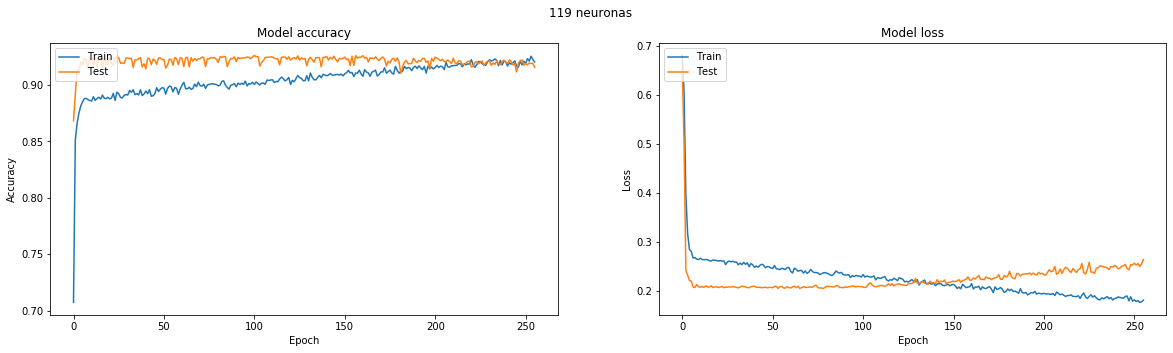

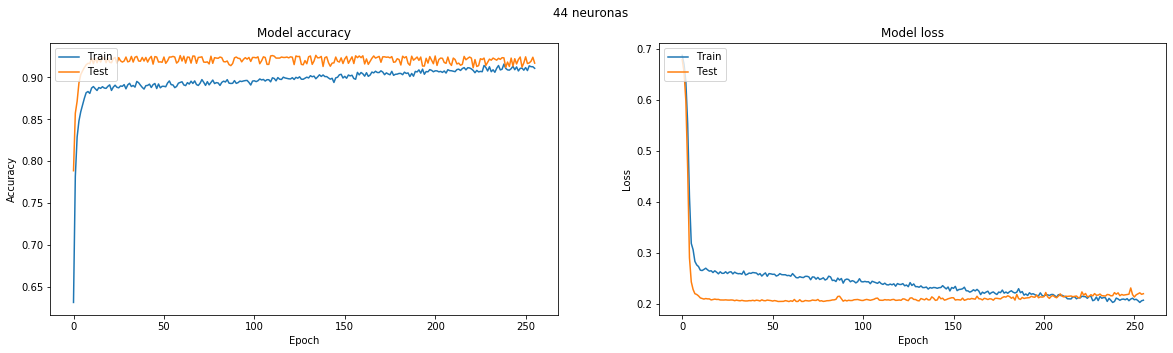

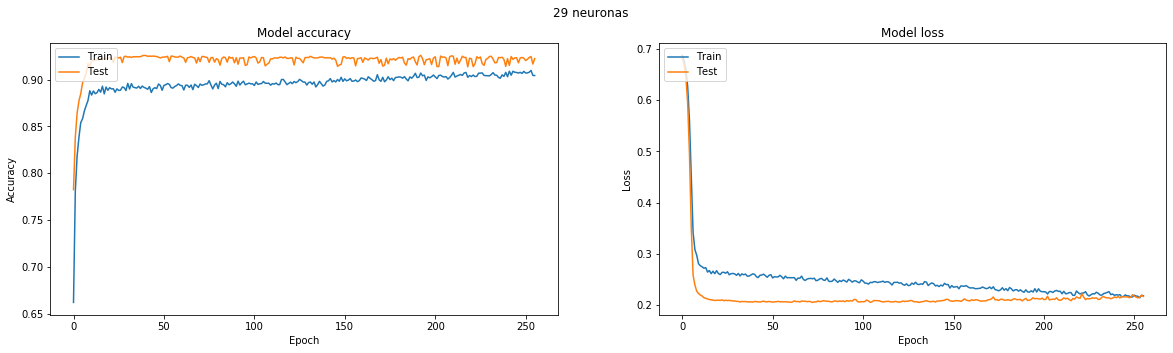

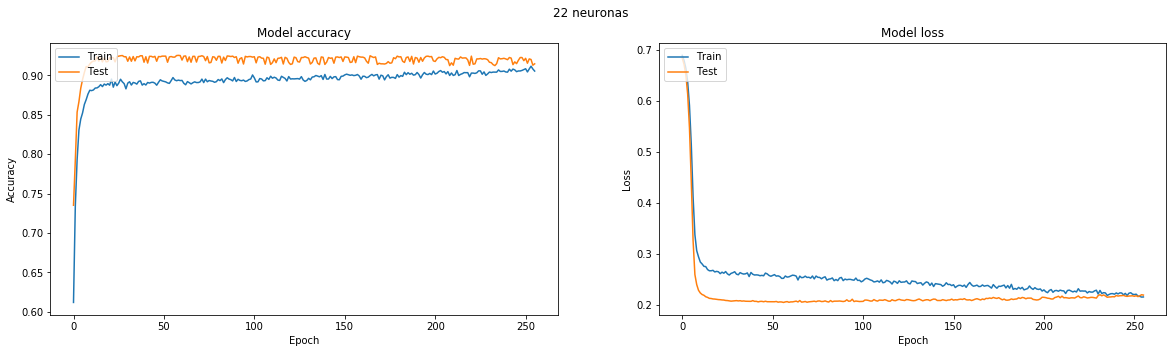

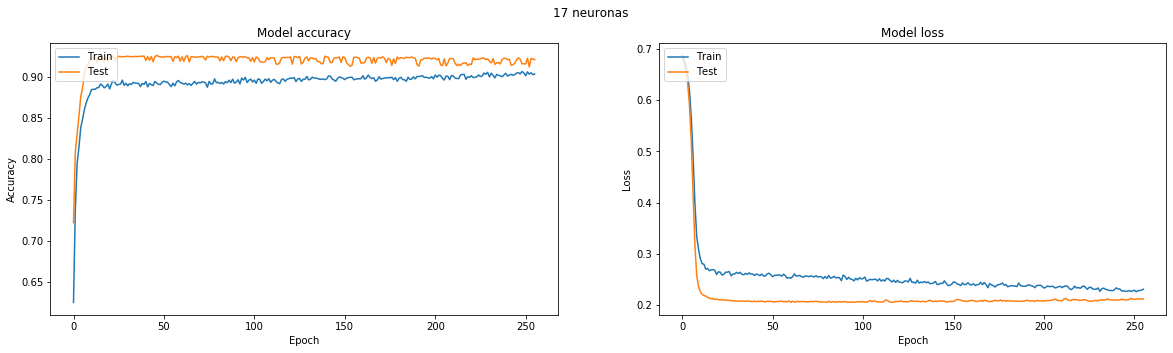

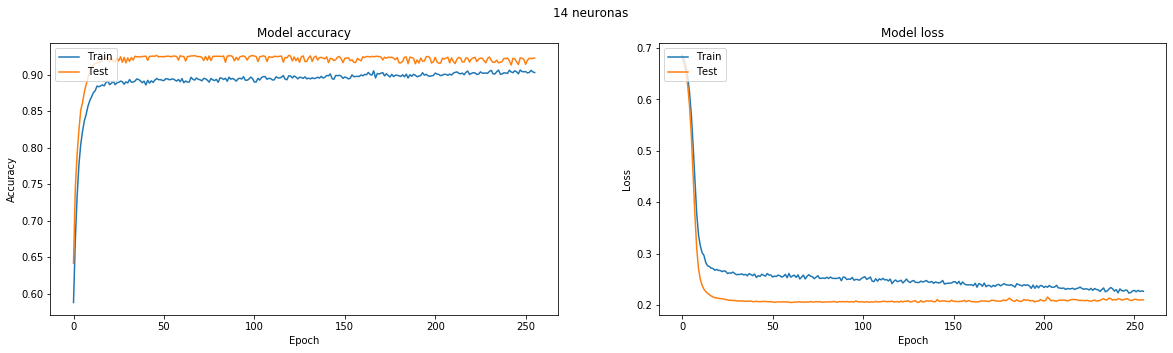

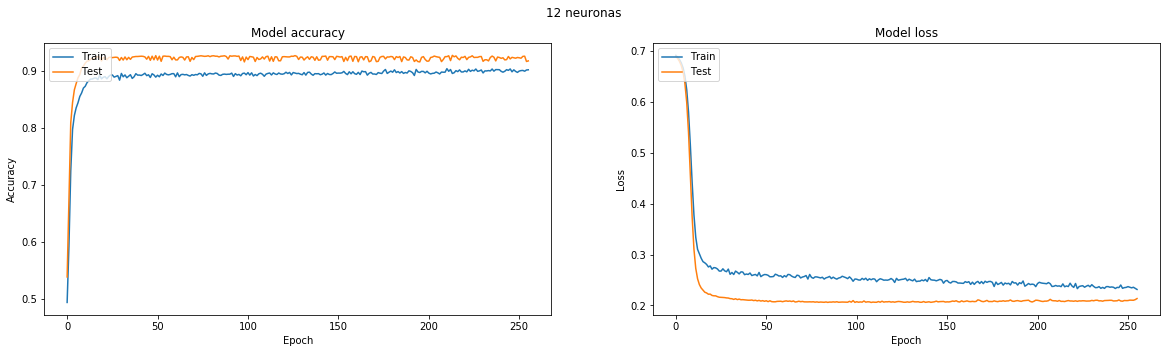

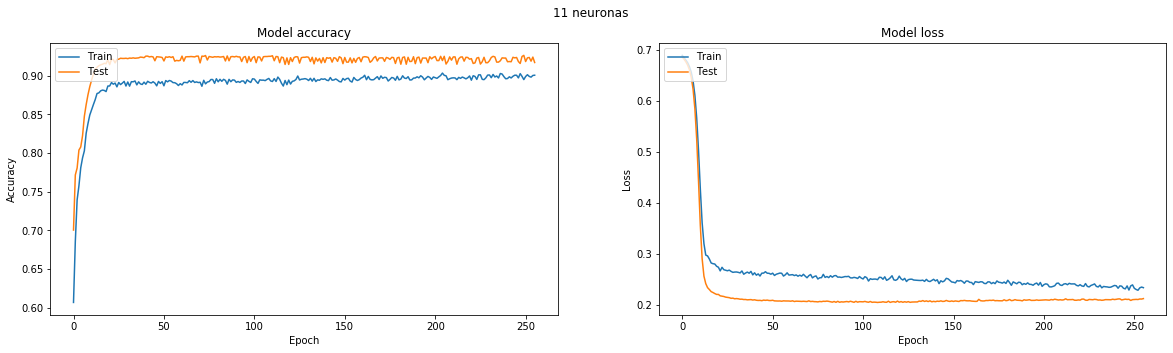

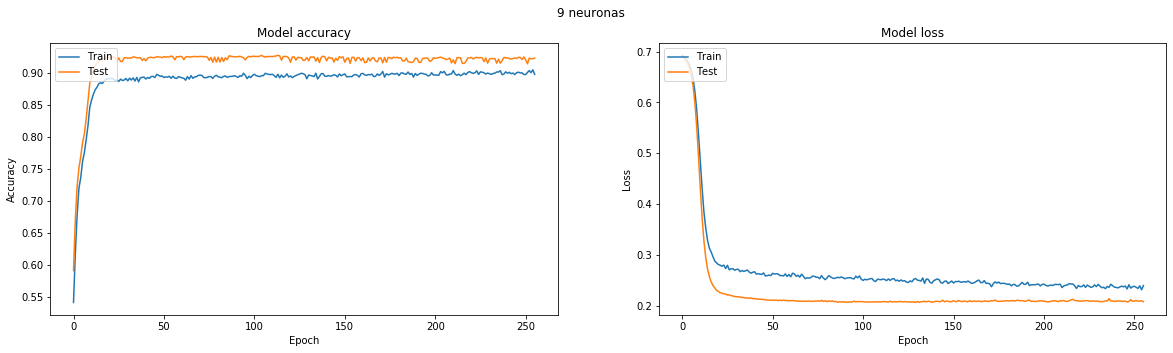

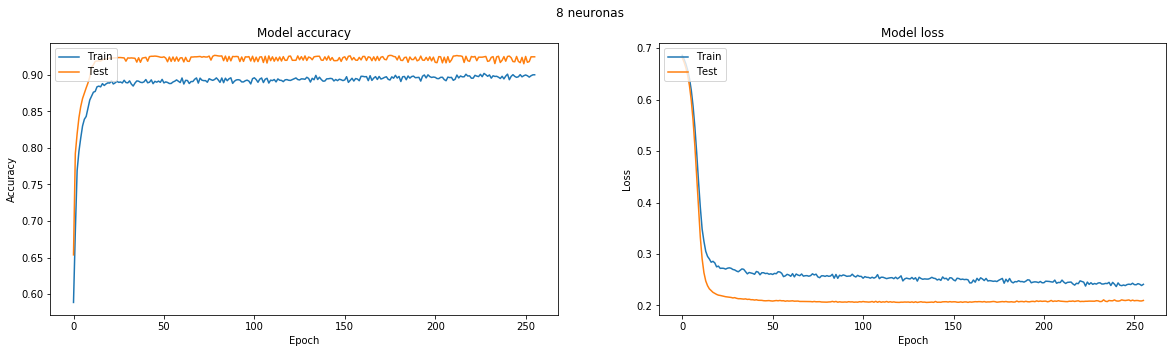

In [146]:
graph_prefix = "no_restricted_standford_with_no"

for (neurons, score, acc, history) in lstm_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(str(neurons) + ' neuronas')
    
    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label= "Train")
    ax1.plot(history.history['val_accuracy'], label= "Test")
    
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc="upper left")
    

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label= "Train")
    ax2.plot(history.history['val_loss'], label= "Test")
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc="upper left")
    
    fig.savefig('./graphs/' + graph_prefix + str(neurons) + '.png')
    
